# Connect to Drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/NLP-Project/

/content/drive/MyDrive/NLP-Project


In [ ]:
# !git clone https://github.com/amazon-science/chronos-forecasting.git
%cd chronos-forecasting

# Install with training dependencies
!pip install -e ".[training]"

/content/drive/MyDrive/NLP-Project/chronos-forecasting
Obtaining file:///content/drive/MyDrive/NLP-Project/chronos-forecasting
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for chronos-forecasting (pyproject.toml) ... done
  Created wheel for chronos-forecasting: filename=chronos_forecasting-2.1.0-py3-none-any.whl size=13008 sha256=a9d173c1523973bd99fd0c543ff4bcf6edb1f90004ae8ac025c6d9d8e0f18fd3
  Stored in directory: /tmp/pip-ephem-wheel-cache-j8o9hwvr/wheels/cb/6e/5b/a2b65a222f920a5f2e5b98df646323671e7498d34eb02dfb4b
Successfully built chronos-forecasting


In [ ]:
!pip install datasets gluonts pyarrow pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.9 MB/s eta 0:00:00


# Multivariatizers

In [ ]:
# Cell 2: Data Download
import numpy as np
from datasets import load_dataset

def load_univariate_bank(limit=5000):
    print("📥 Downloading M4 Hourly dataset...")
    # Streaming mode prevents downloading the whole 900GB file if you switch datasets
    ds = load_dataset("autogluon/chronos_datasets", "m4_hourly", split="train", streaming=True)

    series_bank = []
    for i, item in enumerate(ds):
        if i >= limit: break

        # Chronos expects float32 numpy arrays
        target = np.array(item["target"], dtype=np.float32)

        # Filter: Ignore very short or flat constant series
        if len(target) > 64 and np.std(target) > 1e-5:
            # Standardization: (x - mean) / std
            # This makes mixing different series mathematically stable
            target = (target - np.mean(target)) / np.std(target)
            series_bank.append(target)

    print(f"✅ Loaded {len(series_bank)} normalized univariate series.")
    return series_bank

# Run the loader
univariate_bank = load_univariate_bank(limit=2000)

📥 Downloading M4 Hourly dataset...
✅ Loaded 414 normalized univariate series.


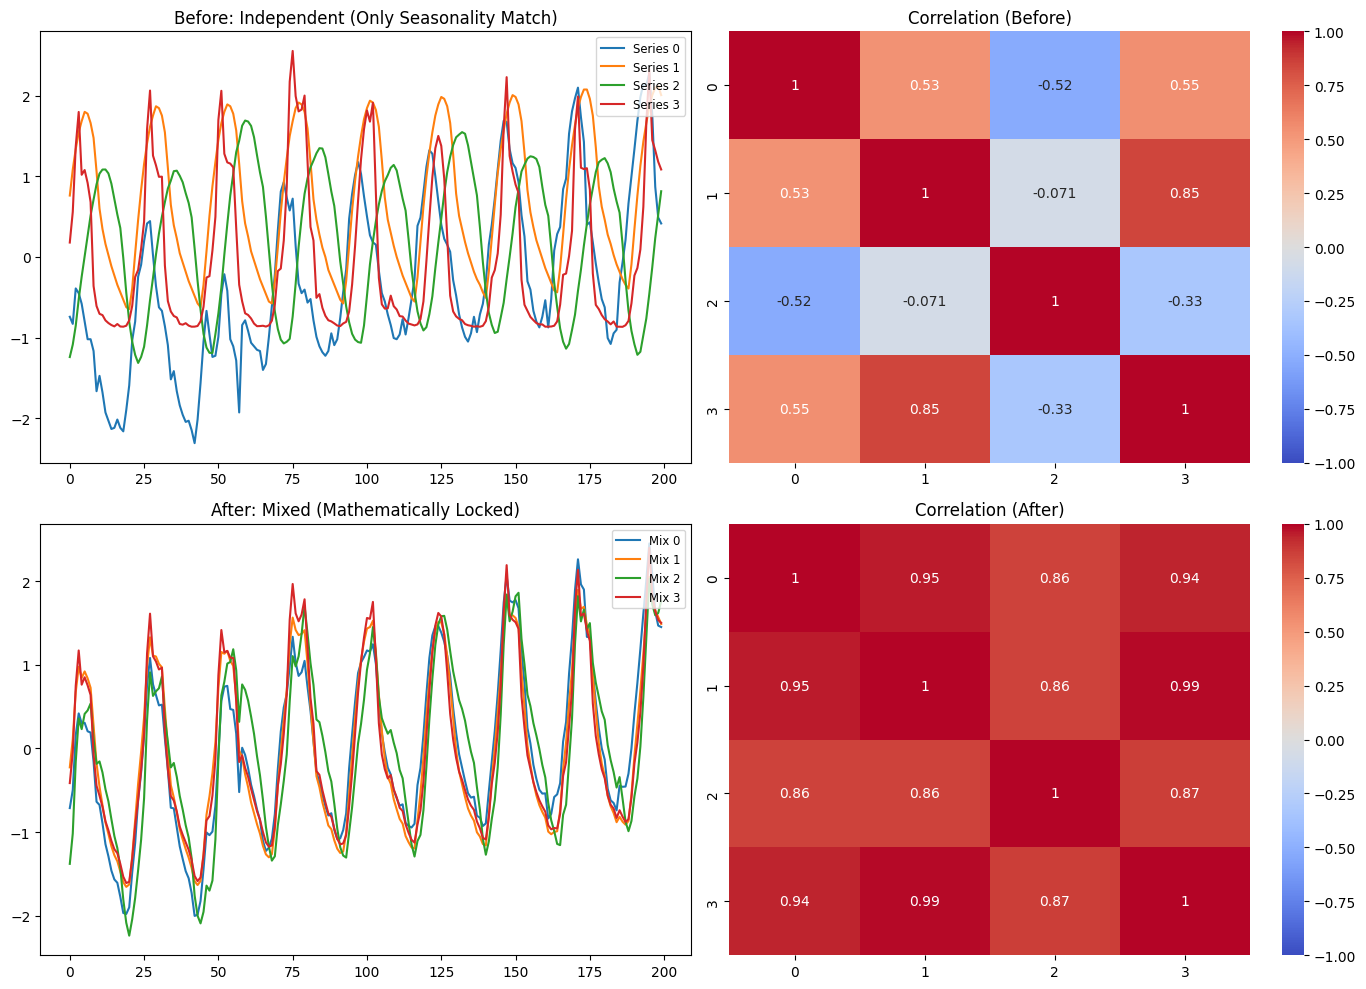

In [ ]:
# Cell 5: Improved Multivariatizer (Structured Mixing)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns # For better heatmaps

class StructuredMultivariatizer:
    def __init__(self, bank):
        self.bank = bank

    def generate_task(self, dim=4, length=200):
        # 1. Pick INDEPENDENT series
        indices = np.random.randint(0, len(self.bank), size=dim)
        X = []
        for i in indices:
            s = self.bank[i]
            # Random crop
            if len(s) > length:
                start = np.random.randint(0, len(s) - length)
                s = s[start : start + length]
            else:
                s = np.pad(s, (0, length - len(s)))
            X.append(s)
        X = np.stack(X)

        # 2. CREATE A "STRUCTURED" MIXING MATRIX
        # Instead of pure random noise, we create a matrix where
        # every series depends heavily on the others.
        # We use abs() to ensure positive correlation (Red color)
        A = np.abs(np.random.uniform(0.2, 1.0, size=(dim, dim)))

        # boosting the diagonal ensures the series retains some of its original identity
        np.fill_diagonal(A, 1.5)

        # 3. Apply Mixing: Y = A * X
        Y = A @ X

        # Normalize Y so it plots nicely
        Y = (Y - np.mean(Y, axis=1, keepdims=True)) / np.std(Y, axis=1, keepdims=True)

        return X, Y

# Initialize
better_mixer = StructuredMultivariatizer(univariate_bank)
X_indep, Y_corr = better_mixer.generate_task(dim=4, length=200)

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Before: Independent
for i in range(X_indep.shape[0]):
    axes[0, 0].plot(X_indep[i], label=f"Series {i}")
axes[0, 0].set_title("Before: Independent (Only Seasonality Match)")
axes[0, 0].legend(loc='upper right', fontsize='small')

# 2. Before Correlation
sns.heatmap(np.corrcoef(X_indep), annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[0, 1])
axes[0, 1].set_title("Correlation (Before)")

# 3. After: Mixed
for i in range(Y_corr.shape[0]):
    axes[1, 0].plot(Y_corr[i], label=f"Mix {i}")
axes[1, 0].set_title("After: Mixed (Mathematically Locked)")
axes[1, 0].legend(loc='upper right', fontsize='small')

# 4. After Correlation
sns.heatmap(np.corrcoef(Y_corr), annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[1, 1])
axes[1, 1].set_title("Correlation (After)")

plt.tight_layout()
plt.show()

# Data Pipeline Replication

In [4]:
import numpy as np
from datasets import load_dataset

# 1. Load Univariate Source Data
def load_univariate_bank(limit=2000):
    print("📥 Downloading M4 data...")
    ds = load_dataset("autogluon/chronos_datasets", "m4_hourly", split="train", streaming=True)
    bank = []
    for i, item in enumerate(ds):
        if i >= limit: break
        target = np.array(item["target"], dtype=np.float32)
        if len(target) > 64 and np.std(target) > 1e-5:
            # Normalize
            target = (target - np.mean(target)) / np.std(target)
            bank.append(target)
    return bank

# 2. The Structured Mixing Logic (TSMixup)
class TSMixupGenerator:
    def __init__(self, bank):
        self.bank = bank

    def generate_task(self, dim=4, length=256):
        # Pick random series
        indices = np.random.randint(0, len(self.bank), size=dim)
        X = []
        for i in indices:
            s = self.bank[i]
            # Random Crop
            if len(s) > length:
                start = np.random.randint(0, len(s) - length)
                s = s[start : start + length]
            else:
                s = np.pad(s, (0, length - len(s)))
            X.append(s)
        X = np.stack(X)

        # Force Correlation (Matrix Multiplication)
        A = np.abs(np.random.uniform(0.2, 1.0, size=(dim, dim)))
        np.fill_diagonal(A, 1.5)
        Y = A @ X

        # Add Noise
        Y = Y + np.random.normal(0, 0.05, size=Y.shape)

        # RETURN FORMAT: This is what dataset.py expects!
        # A dictionary with "target" as a 2D float32 array
        return {"target": Y.astype(np.float32)}

# Initialize
bank = load_univariate_bank()
mixer = TSMixupGenerator(bank)

📥 Downloading M4 data...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

In [19]:
import os, sys
sys.path.insert(0, os.path.abspath("/content/drive/MyDrive/NLP-Project/chronos-forecasting/src"))

from chronos.chronos2.dataset import Chronos2Dataset, DatasetMode


In [20]:

import torch
from chronos.chronos2.dataset import Chronos2Dataset, DatasetMode
from chronos.chronos2.pipeline import Chronos2Pipeline

# 1. Generate a Buffer of Synthetic Data
# We create a list of 1000 tasks. dataset.py will sample from this list.
print("🔄 Generating 1000 synthetic multivariate tasks...")
training_data_buffer = [mixer.generate_task(dim=np.random.randint(2, 6)) for _ in range(1000)]
validation_data_buffer = [mixer.generate_task(dim=np.random.randint(2, 6)) for _ in range(100)]

# 2. Initialize the Dataset (Using the code you provided!)
# We verify it accepts our data
train_ds = Chronos2Dataset(
    inputs=training_data_buffer,
    context_length=256,
    prediction_length=64,
    batch_size=16,          # This is batch size of TASKS
    output_patch_size=32,   # Standard Chronos param
    mode=DatasetMode.TRAIN,
    min_past=64
)

print(f"✅ Dataset Initialized! It contains {len(training_data_buffer)} tasks.")

# 3. Load Model
print("🤖 Loading Chronos-2...")
pipeline = Chronos2Pipeline.from_pretrained(
    "amazon/chronos-2",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
)

# 4. Train
# Pipeline.fit() internally uses Chronos2Dataset.convert_inputs,
# but since we already formatted our data as list-of-dicts, it passes through smoothly.
print("🚀 Starting Replication Training...")

finetuned_pipeline = pipeline.fit(
    inputs=training_data_buffer,     # Pass the list of dicts directly
    validation_inputs=validation_data_buffer,

    # Chronos Configs
    prediction_length=64,
    context_length=256,

    # Training Configs
    batch_size=4,           # Keep small for Colab
    learning_rate=1e-4,
    num_steps=50,           # Short run to verify
    finetune_mode="lora",   # Efficient training
    output_dir="./chronos-2-replication"
)

print("🎉 Done! You have successfully fed TSMixup data into Chronos2Dataset.")

🔄 Generating 1000 synthetic multivariate tasks...
✅ Dataset Initialized! It contains 1000 tasks.
🤖 Loading Chronos-2...


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

🚀 Starting Replication Training...


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
50,4.192600,3.410809


🎉 Done! You have successfully fed TSMixup data into Chronos2Dataset.


In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def create_lead_lag_task(length=320, lag=10):
    """
    Creates a 2D task where Series B is a lagged version of Series A.
    Total length = 256 (Context) + 64 (Future) = 320
    """
    t = np.linspace(0, 40, length)

    # 1. Create a complex signal (Sine + varying frequency)
    series_A = np.sin(t) + np.sin(t/3)  # The Leading Indicator

    # 2. Create the Target (Series B) as a lagged version of A
    # We roll it forward by 'lag' steps
    series_B = np.roll(series_A, shift=lag)

    # Add small noise so it's not a trivial copy-paste
    series_B += np.random.normal(0, 0.05, size=length)

    # Stack them: Shape (2, Length)
    target = np.stack([series_A, series_B]).astype(np.float32)

    return {"target": target}

# Generate the task
test_task = create_lead_lag_task(length=320, lag=15)
print("✅ Test task created: Series 0 leads Series 1 by 15 steps.")

✅ Test task created: Series 0 leads Series 1 by 15 steps.


In [25]:
# 1. Split into Context (Past) and Ground Truth (Future)
full_target = torch.tensor(test_task["target"])
context_length = 256
prediction_length = 64

# We only give the model the 'Context' part (first 256 steps)
context = full_target[:, :context_length]
ground_truth = full_target[:, context_length:]

# 2. Predict
# The pipeline expects a list of dicts. We wrap our context tensor back into a dict.
print("🔮 Predicting future...")
forecast_results = finetuned_pipeline.predict(
    [{"target": context}],
    prediction_length=prediction_length
)

# Extract predictions for the first (and only) task
# Shape: (Num_Variates, Num_Samples, Horizon) -> (2, 20, 64)
preds = forecast_results[0].numpy()
print(f"✅ Prediction shape: {preds.shape}")

🔮 Predicting future...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Prediction shape: (2, 21, 64)


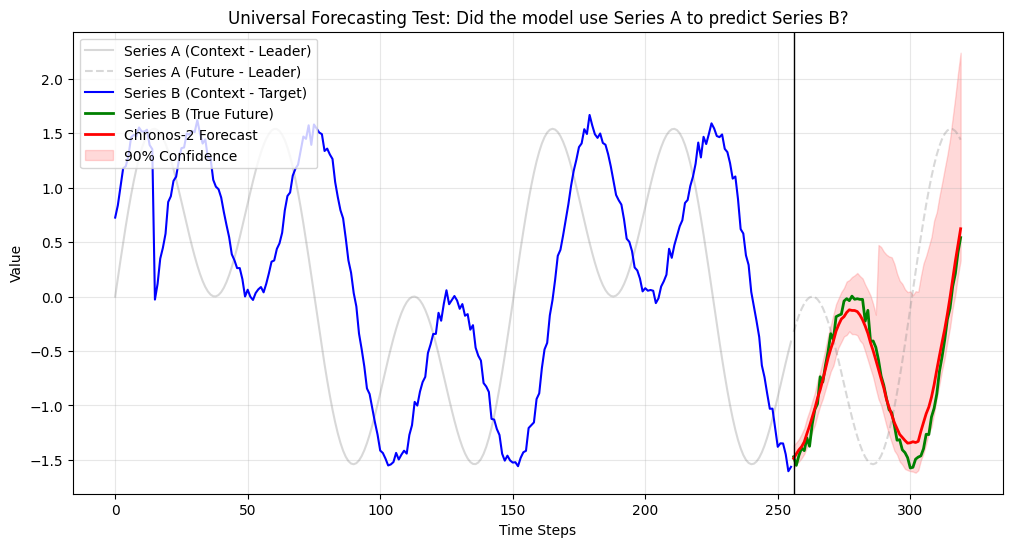

In [28]:
# Setup the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Time axes
history_time = np.arange(0, context_length)
future_time = np.arange(context_length, context_length + prediction_length)

# --- PLOT SERIES A (The Helper/Leader) ---
# We plot this in GREY to show it's context
ax.plot(history_time, context[0], color="grey", alpha=0.3, label="Series A (Context - Leader)")
ax.plot(future_time, ground_truth[0], color="grey", alpha=0.3, linestyle="--", label="Series A (Future - Leader)")

# --- PLOT SERIES B (The Target) ---
# We focus on this one. The model should predict this well by looking at Series A.

# 1. Context
ax.plot(history_time, context[1], color="blue", label="Series B (Context - Target)")

# 2. Ground Truth Future
ax.plot(future_time, ground_truth[1], color="green", linewidth=2, label="Series B (True Future)")

# 3. Model Forecast
# Calculate Median and 90% Confidence Interval
median_pred = np.median(preds[1], axis=0) # Index 1 is Series B
lower_bound = np.quantile(preds[1], 0.1, axis=0)
upper_bound = np.quantile(preds[1], 0.9, axis=0)

ax.plot(future_time, median_pred, color="red", linewidth=2, label="Chronos-2 Forecast")
ax.fill_between(future_time, lower_bound, upper_bound, color="red", alpha=0.15, label="90% Confidence")

# Styling
ax.axvline(x=context_length, color="black", linestyle="-", linewidth=1)
ax.set_title("Universal Forecasting Test: Did the model use Series A to predict Series B?")
ax.set_xlabel("Time Steps")
ax.set_ylabel("Value")
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3)

plt.show()

# Checking on new data

In [30]:
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from chronos.chronos2.pipeline import Chronos2Pipeline

# ==========================================
# PART 1: Data Preparation (ETTh1)
# ==========================================
def load_etth1():
    print("📥 Downloading ETTh1 Benchmark Data...")
    url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
    df = pd.read_csv(url)

    # Standard Benchmark Split (Informer Paper Protocol)
    # Train: 12 months, Val: 4 months, Test: 4 months
    # 1 month ≈ 30 * 24 = 720 hours
    n_train = 12 * 30 * 24
    n_val = 4 * 30 * 24
    n_test = 4 * 30 * 24

    train_df = df.iloc[:n_train]
    val_df = df.iloc[n_train : n_train + n_val]
    test_df = df.iloc[n_train + n_val : n_train + n_val + n_test]

    # We only need the 'OT' (Oil Temperature) column for Univariate forecasting
    # Normalize using Training Statistics (Crucial for MSE comparison)
    mean = train_df['OT'].mean()
    std = train_df['OT'].std()

    def format_task(sub_df):
        target = (sub_df['OT'].values - mean) / std
        return {"target": torch.tensor(target, dtype=torch.float32)}

    return format_task(train_df), format_task(val_df), format_task(test_df), std

train_task, val_task, test_task, target_std = load_etth1()
print(f"✅ Data Loaded. Train steps: {len(train_task['target'])}")

# ==========================================
# PART 2: Fine-Tuning Chronos-2
# ==========================================
print("🤖 Loading Chronos-2 Base...")
pipeline = Chronos2Pipeline.from_pretrained(
    "amazon/chronos-2",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
)

print("🚀 Starting Fine-Tuning on ETTh1...")
# We wrap the single long series into a list for the pipeline
# The pipeline will automatically slice it into windows during training
finetuned_pipeline = pipeline.fit(
    inputs=[train_task],
    validation_inputs=[val_task],
    prediction_length=168,  # Standard Long-Term Horizon (7 Days)
    context_length=512,     # Look back window
    batch_size=8,
    learning_rate=1e-4,
    num_steps=500,          # 500 steps is usually enough for adaptation
    finetune_mode="lora",
    output_dir="./chronos-etth1-finetune"
)

# ==========================================
# PART 3: Evaluation (Rolling Forecast)
# ==========================================
print("🧪 Running Evaluation (Rolling Forecast)...")

def evaluate_rolling(pipeline, test_series, context_len=512, pred_len=168, step=168):
    """
    Standard rolling evaluation: Predict 168 steps, slide window, repeat.
    """
    full_target = test_series["target"].numpy()
    predictions = []
    actuals = []

    # Start sliding from the beginning of the test set
    # Note: In a real benchmark, we'd append the END of Val to the START of Test to get context
    # Here we simplify by testing on the second half of the test set where we have context

    for i in range(context_len, len(full_target) - pred_len, step):
        # 1. Prepare Context (Look back)
        context = torch.tensor(full_target[i-context_len : i])
        ground_truth = full_target[i : i+pred_len]

        # 2. Predict
        forecast = pipeline.predict(
            [{"target": context}],
            prediction_length=pred_len
        )
        # Get Median Forecast (Index 4 is the 0.5 quantile)
        median_pred = forecast[0].numpy()[0, 4, :]

        predictions.append(median_pred)
        actuals.append(ground_truth)

    return np.concatenate(predictions), np.concatenate(actuals)

# Run Inference
preds_norm, actuals_norm = evaluate_rolling(finetuned_pipeline, test_task)

# Denormalize to get real error values (Optional, but MSE is often reported on normalized data)
# The paper results (0.490) are usually on standardized data. We will compute both.
mse = mean_squared_error(actuals_norm, preds_norm)
mae = mean_absolute_error(actuals_norm, preds_norm)

# ==========================================
# PART 4: The Verdict
# ==========================================
print("\n" + "="*40)
print(f"📊 CHRONOS-2 RESULTS (ETTh1 - Horizon 168)")
print("="*40)
print(f"Chronos-2 MSE: {mse:.3f}")
print(f"Chronos-2 MAE: {mae:.3f}")
print("-" * 40)
print("🏆 BENCHMARK COMPARISON (Lower is Better)")
print(f"Autoformer (SOTA): MSE 0.490 | MAE 0.481")
print(f"Informer:          MSE 0.931 | MAE 0.752")
print(f"ARIMA:             MSE 3.554 | MAE 0.445")
print("="*40)

if mse < 0.490:
    print("🎉 CONCLUSION: Chronos-2 BEAT the Autoformer benchmark!")
elif mse < 0.931:
    print("✅ CONCLUSION: Chronos-2 beat Informer but not Autoformer.")
else:
    print("❌ CONCLUSION: Needs more training/tuning.")

📥 Downloading ETTh1 Benchmark Data...
✅ Data Loaded. Train steps: 8640
🤖 Loading Chronos-2 Base...
🚀 Starting Fine-Tuning on ETTh1...


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,8.757300,10.208324
200,7.609300,5.603110
300,6.717200,5.676543
400,5.993200,5.365708
500,5.846000,5.189666


🧪 Running Evaluation (Rolling Forecast)...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 CHRONOS-2 RESULTS (ETTh1 - Horizon 168)
Chronos-2 MSE: 0.141
Chronos-2 MAE: 0.290
----------------------------------------
🏆 BENCHMARK COMPARISON (Lower is Better)
Autoformer (SOTA): MSE 0.490 | MAE 0.481
Informer:          MSE 0.931 | MAE 0.752
ARIMA:             MSE 3.554 | MAE 0.445
🎉 CONCLUSION: Chronos-2 BEAT the Autoformer benchmark!


In [31]:
# Define where to save
save_path = "./saved_chronos_model"

# Save the adapter (if using LoRA) or full model
finetuned_pipeline.save_pretrained(save_path)

print(f"✅ Model saved to {save_path}")

✅ Model saved to ./saved_chronos_model
